In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam
from model.bool_logic import BoolLogic
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

logic = BoolLogic()

In [3]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class BinaryDataset(Dataset):
    def __init__(self, shape, N):
        self.samples = torch.distributions.bernoulli.Bernoulli(
            0.5
        ).sample(
            torch.Size([N, *shape])
        ).bool()
        
    def __len__(self):
        return self.samples.size(0)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [4]:
ds = BinaryDataset([30], 10_000)
sampler = RandomSampler(ds, replacement=True, num_samples=100_000)
loader = DataLoader(ds, batch_size=64, sampler=sampler)

In [5]:
def rand_n_true(shape, N):
    falses = torch.zeros(shape, dtype=torch.bool)
    falses = falses.view(-1)
    falses[:N] = True
    falses = falses[torch.randperm(falses.size(0))]
    return falses.view(*shape)

In [6]:
weights = rand_n_true([30], 3).cuda()

In [7]:
def train_conj(model, optim):

    losses = []

    for bs in tqdm(loader):
        bs = bs.cuda()
        cjs = logic.conjoin(logic.implies(weights, bs), dim=1)
        cj_hats = cj_model(flogic.encode(bs)).squeeze()
        #loss = ((cjs.float() - cj_hats).abs()).mean()
        loss = (cj_model._logic.bin_xor(flogic.encode(cjs), cj_hats) ** 2).mean()
        losses.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

    return torch.Tensor(losses)

In [8]:
flogic = ProductLogic().cuda()
cj_model = FuzzyUnsignedConjunction(in_features=30, out_features=1, logic=flogic).cuda()
optim = torch.optim.Adam(cj_model.parameters(), lr=1e-2)

In [9]:
losses = train_conj(cj_model, optim)

  0%|          | 0/1563 [00:00<?, ?it/s]

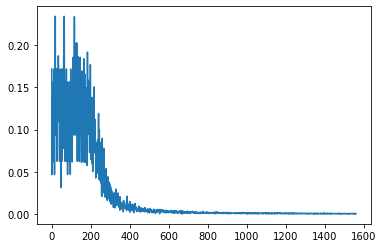

In [10]:
plt.plot(losses)

In [11]:
(cj_model.weights.value() > 0.5).flatten()

tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [12]:
weights

tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False, False],
       device='cuda:0')